In [78]:
import os
import subprocess
import concurrent.futures
import pandas as pd

# Mapping from preset names to extra info.
# Adjust these values to match what you set in your CMakePresets.json.
preset_info = {
    "gcc-O3":   {"compiler": "gcc",   "optimization_flags": "-O3"},
    "clang-O3": {"compiler": "clang", "optimization_flags": "-O3"},
    "icx-O3":   {"compiler": "icx",   "optimization_flags": "-O3"},
    "gcc-O2":   {"compiler": "gcc",   "optimization_flags": "-O2"},
    "clang-O2": {"compiler": "clang", "optimization_flags": "-O2"},
    "icx-O2":   {"compiler": "icx",   "optimization_flags": "-O2"}
}



def build_and_run(preset, L=1000):
    """
    Build and run the binary for a given preset.
    
    Parameters:
        preset (str): The name of the preset from CMakePresets.json.
        L (int): The problem size to pass to the binary.
    
    Returns:
        dict: Contains keys: compiler, optimization_flags, L, metric, error.
    """
    # For any preset starting with 'icx', check if the oneAPI environment script exists.
    env_prefix = ""
    if preset.lower().startswith("icx"):
        setvars_path = '/opt/intel/oneapi/setvars.sh'
        if not os.path.exists(setvars_path):
            return {
                "compiler": preset_info[preset]["compiler"],
                "optimization_flags": preset_info[preset]["optimization_flags"],
                "L": L,
                "metric": None,
                "error": f"Skipping {preset}: {setvars_path} not found"
            }
        env_prefix = f"source {setvars_path} && "

    # Configure step: Use CMake presets to configure.
    configure_cmd = (
        env_prefix +
        f"cmake --preset {preset}"
    )

    # Build step: Use CMake presets to build.
    build_cmd = (
        env_prefix +
        f"cmake --build --preset {preset}_build_preset"
    )


    print(f"Building preset '{preset}' ...")
    try:
        configure_result = subprocess.run(
            configure_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True,
            executable="/bin/bash"
        )
        build_result = subprocess.run(
            build_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True,
            executable="/bin/bash"
        )
        # Check if the build (compilation) failed.
        if build_result.returncode != 0 or configure_result.returncode != 0 :
            error_msg = f"Build failed: {build_result.stderr}"
            print(f"Compilation failed for preset {preset}: {error_msg}")
            return {
                "compiler": preset_info[preset]["compiler"],
                "optimization_flags": preset_info[preset]["optimization_flags"],
                "L": L,
                "metric": None,
                "error": error_msg
            }
    except Exception as e:
        return {
            "compiler": preset_info[preset]["compiler"],
            "optimization_flags": preset_info[preset]["optimization_flags"],
            "L": L,
            "metric": None,
            "error": str(e)
        }
    
    # The binary is assumed to be located at out/<preset>/bin/tiny_ising.
    binary_path = os.path.abspath(os.path.join("out", preset, "bin", "tiny_ising"))
    if not os.path.exists(binary_path) or not os.access(binary_path, os.X_OK):
        return {
            "compiler": preset_info[preset]["compiler"],
            "optimization_flags": preset_info[preset]["optimization_flags"],
            "L": L,
            "metric": None,
            "error": "Binary not found or not executable"
        }
    
    # Run the binary, passing L as an argument.
    run_cmd = f"{binary_path} {L}"
    try:
        run_result = subprocess.run(
            run_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True
        )
        if run_result.returncode != 0:
            return {
                "compiler": preset_info[preset]["compiler"],
                "optimization_flags": preset_info[preset]["optimization_flags"],
                "L": L,
                "metric": None,
                "error": f"Run failed: {run_result.stderr}"
            }
        # Convert output to float as metric.
        metric = float(run_result.stdout.strip())
        return {
            "compiler": preset_info[preset]["compiler"],
            "optimization_flags": preset_info[preset]["optimization_flags"],
            "L": L,
            "metric": metric,
            "error": None
        }
    except Exception as e:
        return {
            "compiler": preset_info[preset]["compiler"],
            "optimization_flags": preset_info[preset]["optimization_flags"],
            "L": L,
            "metric": None,
            "error": str(e)
        }

# List of presets to test.
presets = list(preset_info.keys())
L = 1000  # Example problem size.

results = []
# Run each combination in parallel.
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(build_and_run, preset, L) for preset in presets]
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        print(result)
        results.append(result)

# Build a pandas DataFrame from the results.
df = pd.DataFrame(results)
print("\nFinal Results DataFrame:")
print(df)

# Optionally, save the DataFrame to a CSV file.
df.to_csv("build_run_results.csv", index=False)


Building preset 'gcc-O3' ...Building preset 'clang-O3' ...

Building preset 'icx-O3' ...
Building preset 'gcc-O2' ...
Building preset 'clang-O2' ...
Building preset 'icx-O2' ...
{'compiler': 'icx', 'optimization_flags': '-O2', 'L': 1000, 'metric': 22.460957, 'error': None}
{'compiler': 'clang', 'optimization_flags': '-O2', 'L': 1000, 'metric': 25.68744, 'error': None}
{'compiler': 'gcc', 'optimization_flags': '-O3', 'L': 1000, 'metric': 27.245418, 'error': None}
{'compiler': 'icx', 'optimization_flags': '-O3', 'L': 1000, 'metric': 25.327593, 'error': None}
{'compiler': 'gcc', 'optimization_flags': '-O2', 'L': 1000, 'metric': 28.660151, 'error': None}
{'compiler': 'clang', 'optimization_flags': '-O3', 'L': 1000, 'metric': 29.463234, 'error': None}

Final Results DataFrame:
  compiler optimization_flags     L     metric error
0      icx                -O2  1000  22.460957  None
1    clang                -O2  1000  25.687440  None
2      gcc                -O3  1000  27.245418  None
3    

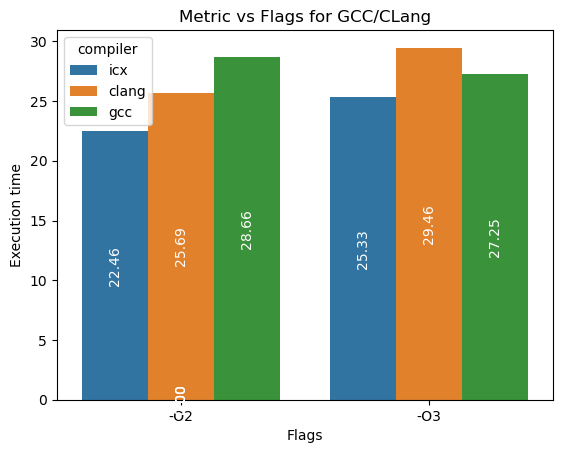

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.barplot(x='optimization_flags', y='metric', hue='compiler', data=df)
# Add labels with the value of each bar
for rect in ax.patches:
    # Get the height and width of the bar
    height = rect.get_height()
    width = rect.get_width()

    # Get the x and y coordinates of the bar
    x = rect.get_x()
    y = rect.get_y()

    # Add a label with the value of the bar
    ax.text(x + width/2, y + height/2, '{:.2f}'.format(height), ha='center', va='center', color='white', rotation=90)

# Set the plot title and axis labels
plt.title('Metric vs Flags for GCC/CLang/icx')
plt.xlabel('Flags')
plt.ylabel('Execution time')
# plt.xticks(df.L.unique(), rotation=90)

# Show the plot
plt.show()